# Goal: Analyze the purchased marchandise history and predict which customer is likely to buy the new product X (0 - not purchased, 1 - purchased).

### About the datasets:
**user_table.csv**
<li> A table containing the information of users who have been offered the new product X
<li> There are some missing values and duplicate data<br>
    
**historical_transactions_AtoI.csv**
<li> A table containing the purchase history of products A - I which was previously sold.<br>
    
**historical_transactions_X.csv**
<li> A table containing the purchase hisotri of product X which is currently being promoted.

# 1. Explore The Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
sns.set_style(style='dark')

# enable to show multiple outputs of 1 cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
users = pd.read_csv('user_table.csv')
historical_transaction = pd.read_csv('historical_transactions_AtoI.csv')
X_transaction = pd.read_csv('historical_transactions_X.csv')

In [3]:
users.head(3)
historical_transaction.head(3)
X_transaction.head(3)

,user_id,name,nickname,age,country,num_family,married,job,income,profile
0,14742,Richard Chen,kathryn77,20.0,NaN,1.0,0.0,Human resources officer,394.0,Last sit star physical accept. Actually relate...
1,21530,Kayla Garcia,brandtalexander,59.0,Saint Kitts and Nevis,4.0,0.0,"Teacher, early years/pre",370.0,Door entire as. Whose suddenly mission hold.\n...
2,34985,Troy Blackwell,richardfarmer,44.0,Iraq,3.0,2.0,Forensic psychologist,326.0,Writer drug a tax. Team standard both write pr...


,user_id,price,num_purchase,item
0,0,867,3,C
1,0,947,2,F
2,0,815,2,D


,user_id,price,num_purchase,item
0,1,137,1,X
1,7,137,1,X
2,9,137,1,X


### Deleting duplicate data

In [4]:
names = ['users', 'historical_transaction', 'X_transaction']
dfs = [users, historical_transaction, X_transaction]

for name, df in zip(names, dfs):
    print(f'{name} - shape before: {df.shape}')
    df.drop_duplicates(inplace=True)
    df.reset_index(drop=True, inplace=True)
    print(f'{name} - shape after: {df.shape}')

users - shape before: (50103, 10)
users - shape after: (50000, 10)
historical_transaction - shape before: (169379, 4)
historical_transaction - shape after: (152200, 4)
X_transaction - shape before: (6444, 4)
X_transaction - shape after: (5618, 4)


### Combining the data
<li> if X >= 1 (purchased X more than one), X = 1
<li> if X == 0 (did not purchase X), X = 0

In [5]:
# calculate the total number of purchase for each item A-I
pv_ht = pd.pivot_table(historical_transaction, index='user_id', columns='item', values='num_purchase', 
                      aggfunc = 'sum').reset_index()
users_item_num = pd.merge(users, pv_ht, how='left', on='user_id')
users_item_num[historical_transaction.item.unique()] = users_item_num[historical_transaction.item.unique()].fillna(0)

# calculate the total number of purchase for item X
pv_pt = pd.pivot_table(X_transaction, index='user_id', columns='item', values='num_purchase',
                      aggfunc = 'sum').reset_index()
users_item_num = pd.merge(users_item_num, pv_pt, how='left', on='user_id')
users_item_num[X_transaction.item.unique()] = users_item_num[X_transaction.item.unique()].fillna(0)

# replace the value of X to 0 or 1
users_item_num['X'] = users_item_num['X'].apply(lambda x: 1 if x >= 1 else 0).values

users_item_num.head(3)


,user_id,name,nickname,age,country,num_family,married,job,income,profile,A,B,C,D,E,F,G,H,I,X
0,14742,Richard Chen,kathryn77,20.0,NaN,1.0,0.0,Human resources officer,394.0,Last sit star physical accept. Actually relate...,3.0,3.0,2.0,0.0,2.0,0.0,0.0,1.0,2.0,0
1,21530,Kayla Garcia,brandtalexander,59.0,Saint Kitts and Nevis,4.0,0.0,"Teacher, early years/pre",370.0,Door entire as. Whose suddenly mission hold.\n...,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,1
2,34985,Troy Blackwell,richardfarmer,44.0,Iraq,3.0,2.0,Forensic psychologist,326.0,Writer drug a tax. Team standard both write pr...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


### Visualize data

**'grouping':** データフレームの特定の列に対して、指定したkeys/valuesでの集約特徴量を計算する<br>

**'plot_target_stats':** grouping で作成したデータに関して、次の値に関する２軸グラフの作成を行う
<li> X_count: key ごとのレコード数
<li> X_mean: key ごとのXの平均値

In [6]:
# 'grouping' - group the specified row of df by keys and values
def grouping(df, cols, agg_dict, prefix=''):
    """
        df: 特徴量作成の元になるdf
        cols (str or list):　groupby処理のkeyとなるカラム
        agg_dict (dict):　特徴量作成を行いたいカラム/集計方法を指定するdictionary
        prefix (str):　集約後のカラムに付与するprefix name
    """
    group_df = df.groupby(cols).agg(agg_dict)
    group_df.columns = [prefix + c[0] +'_' +c[1] for c in list(group_df.columns)]
    group_df.reset_index(inplace = True)
    
    return group_df

# create a 2 axis graph of X_count and X_mean based on the data created by 'grouping'
def plot_target_stats(df, col, agg_dict, plot_config):
    plt_data = grouping(df,col, agg_dict, prefix='')
    
    # create 2 axis graph
    fig, ax1 = plt.subplots(figsize = (15,7))
    
    ax2 = ax1.twinx()
    
    ax1.bar(plt_data[col], plt_data['X_count'], label='X_count', color='skyblue', **plot_config['bar'])
    ax2.plot(plt_data[col], plt_data['X_mean'], label='X_mean', color='red', marker='.',markersize=10)
    
    h1, label1 = ax1.get_legend_handles_labels()
    h2, label2 = ax2.get_legend_handles_labels()

    ax1.legend(h1 + h2, label1 + label2, loc=2, borderaxespad=0.)
    ax1.set_xticks(plt_data[col])
    ax1.set_xticklabels(plt_data[col], rotation=-90, fontsize=10)
    
    ax1.set_title(f'Relationship between {col}, X_count, and X_mean', fontsize=14)
    ax1.set_xlabel(f'{col}')
    ax1.tick_params(labelsize=12)
    
    ax1.set_ylabel('X_count')
    ax2.set_ylabel('X_mean')
    
    ax1.set_ylim([0, plt_data['X_count'].max() * 1.2])
    ax2.set_ylim([0, plt_data['X_mean'].max() * 1.1])
    


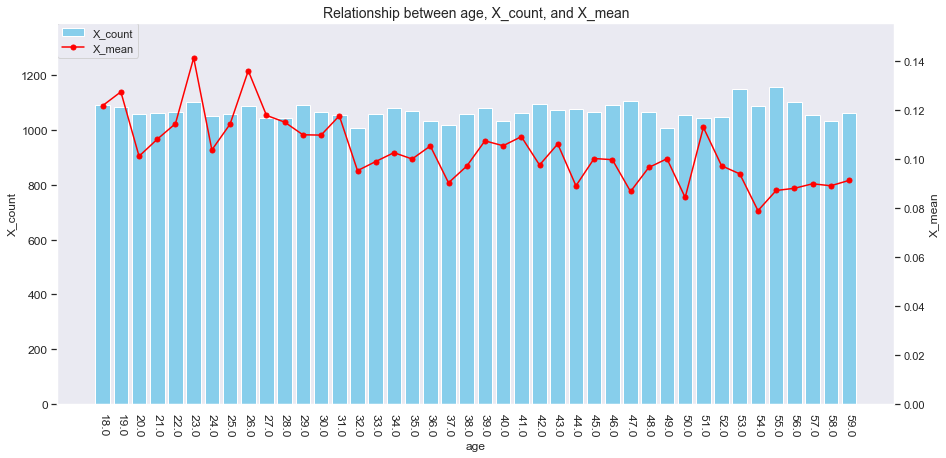

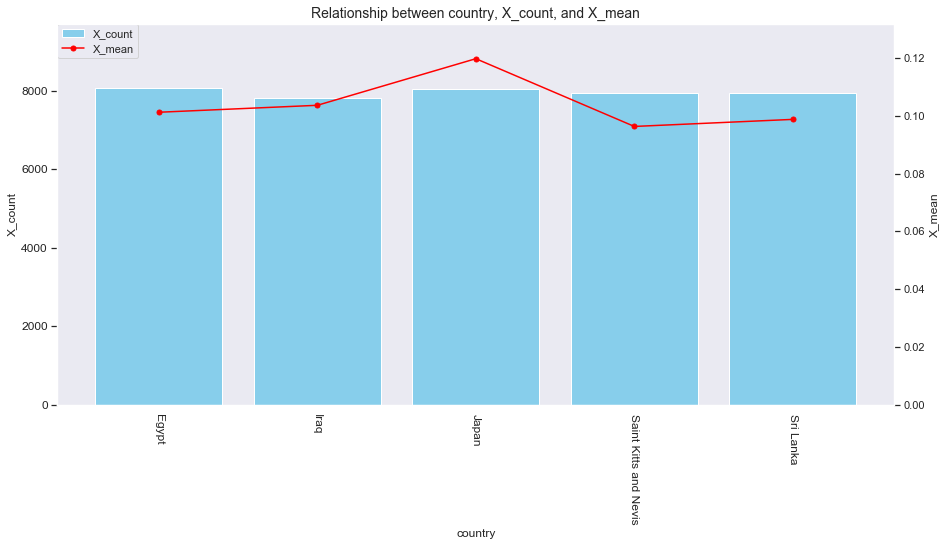

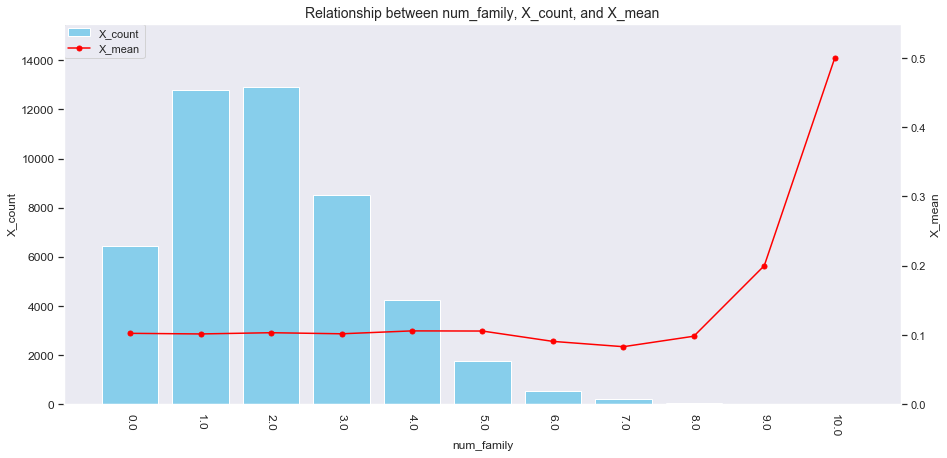

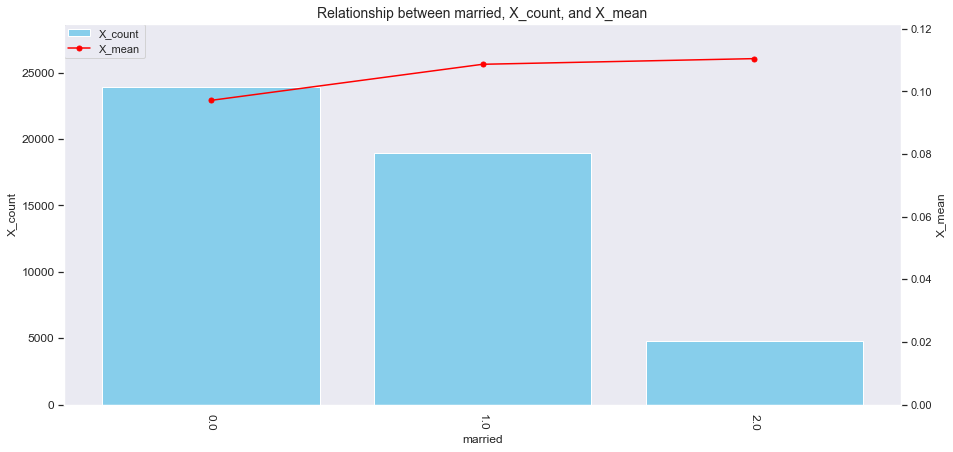

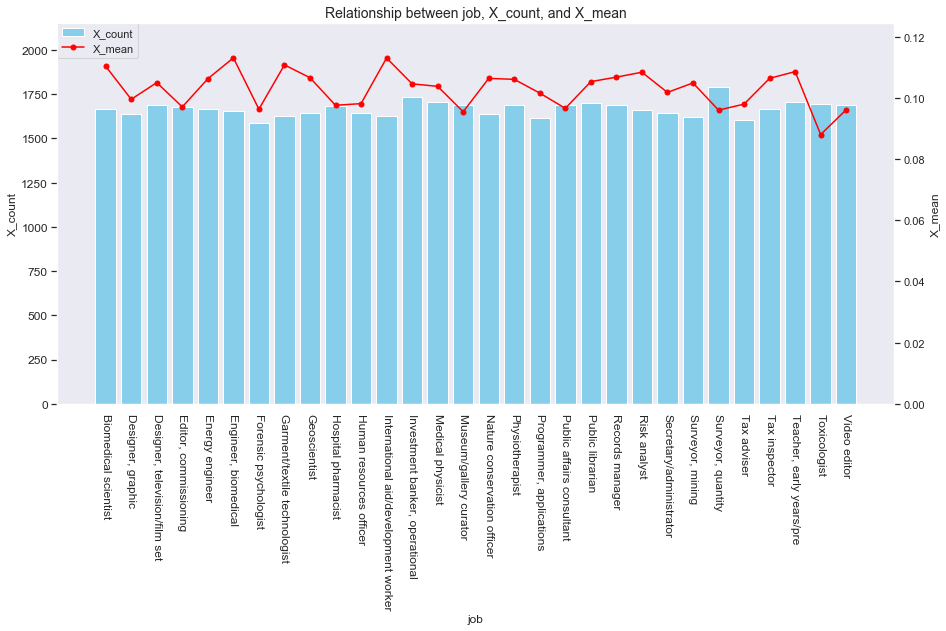

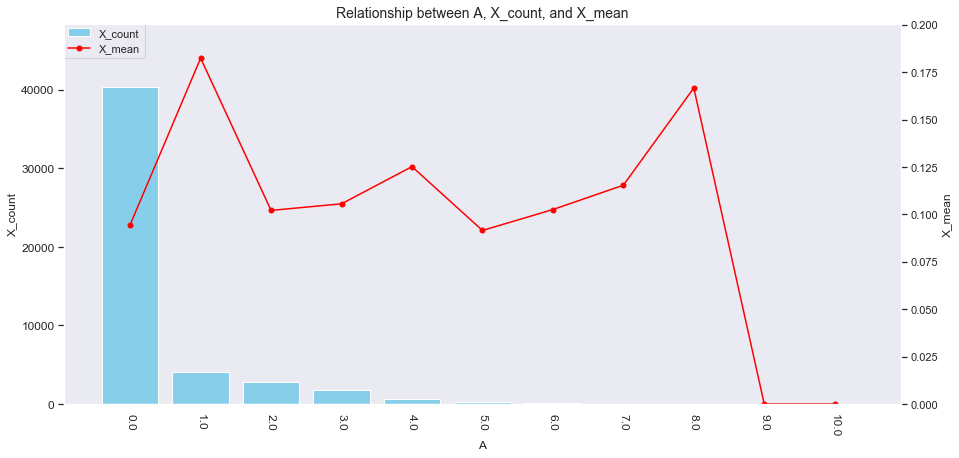

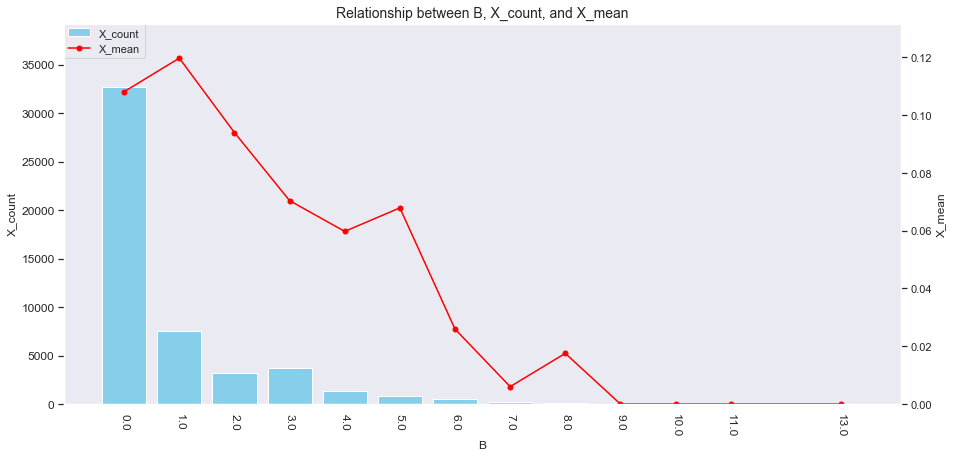

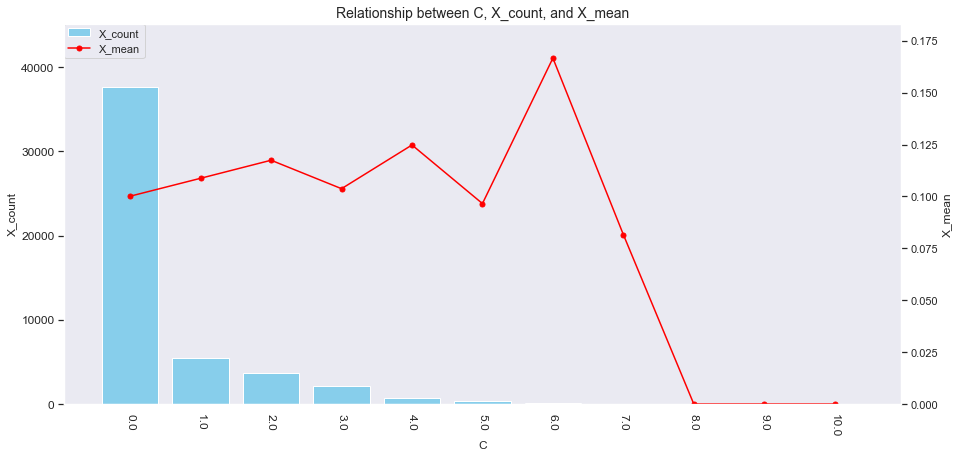

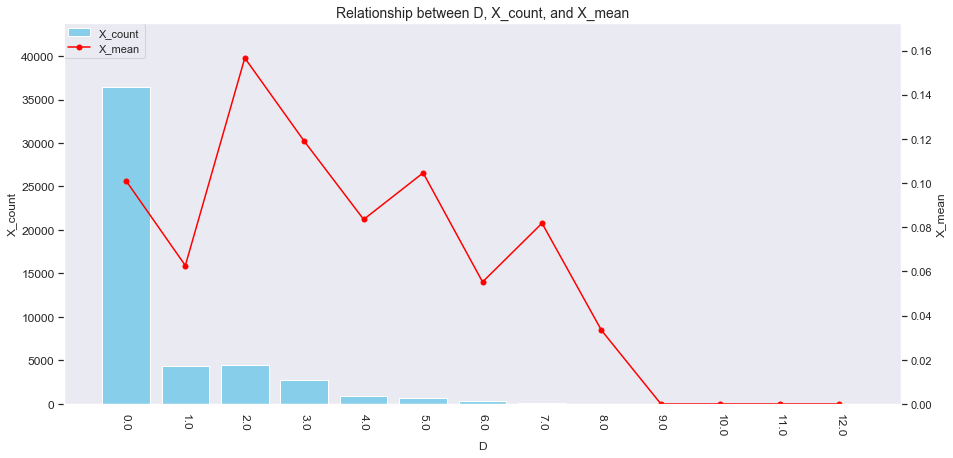

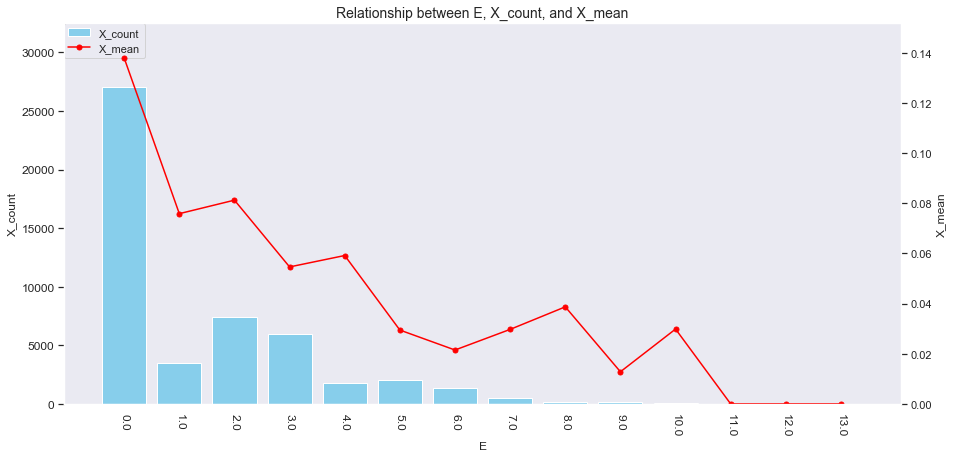

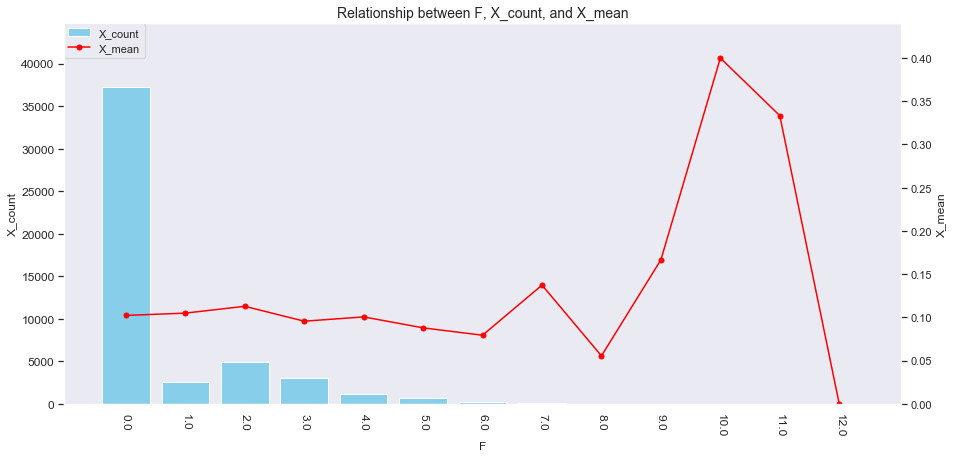

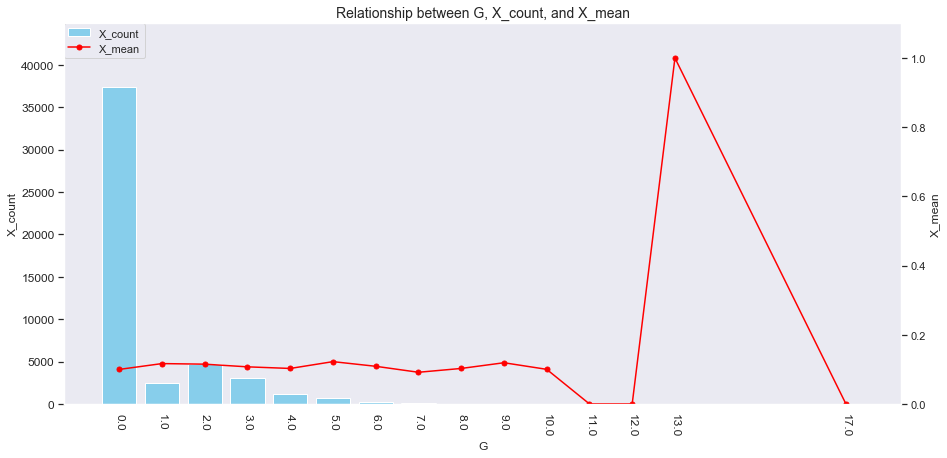

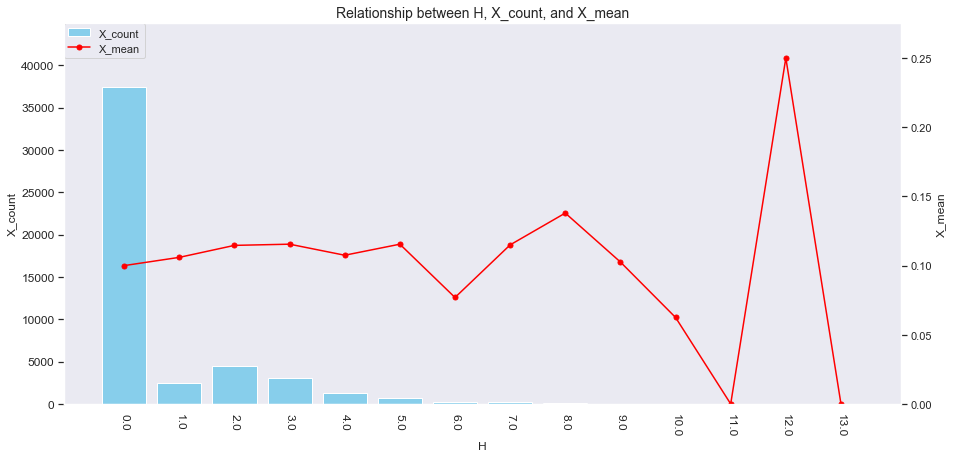

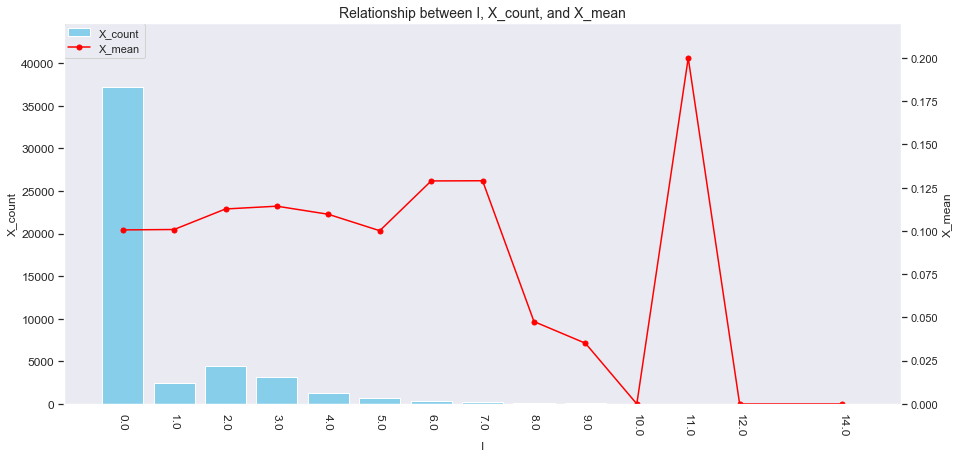

In [7]:
for col in ['age', 'country', 'num_family', 'married', 'job','A','B','C','D','E','F','G','H','I']:
    agg_dict = { 'X' : ['count', 'mean'] }
    
    plot_config = {'bar': {'width':0.8}}
    plot_target_stats(users_item_num, col, agg_dict, plot_config)

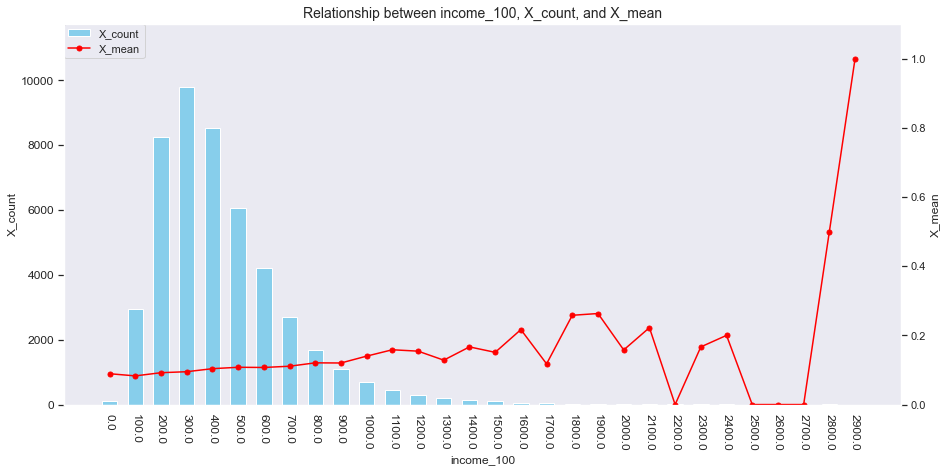

In [8]:
# income は連続変数なため、１００単位にまとめる
tmp_df = users_item_num.copy()
tmp_df['income_100'] = (tmp_df['income'] // 100 * 100)

plot_config = {'bar': {'width': 60}}
plot_target_stats(tmp_df, 'income_100', agg_dict, plot_config)

### Checking Missing values

In [9]:
#　各カラムの欠損値の数
names = ['users', 'historical_transaction', 'X_transaction']
dfs = [users, historical_transaction, X_transaction]

for name, df in zip(names, dfs):
    print('=============================================')
    print(f'{name} : null value - counts')
    print('=============================================')
    print(df.isnull().sum())


users : null value - counts
user_id           0
name              0
nickname          0
age            5126
country       10134
num_family     2563
married        2447
job               0
income         2519
profile           0
dtype: int64
historical_transaction : null value - counts
user_id         0
price           0
num_purchase    0
item            0
dtype: int64
X_transaction : null value - counts
user_id         0
price           0
num_purchase    0
item            0
dtype: int64


In [10]:
for name, df in zip(names, dfs):
    print('==============================')
    print(f'{name} : info')
    print('==============================')
    df.info()

users : info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 10 columns):
user_id       50000 non-null int64
name          50000 non-null object
nickname      50000 non-null object
age           44874 non-null float64
country       39866 non-null object
num_family    47437 non-null float64
married       47553 non-null float64
job           50000 non-null object
income        47481 non-null float64
profile       50000 non-null object
dtypes: float64(4), int64(1), object(5)
memory usage: 3.8+ MB
historical_transaction : info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152200 entries, 0 to 152199
Data columns (total 4 columns):
user_id         152200 non-null int64
price           152200 non-null int64
num_purchase    152200 non-null int64
item            152200 non-null object
dtypes: int64(3), object(1)
memory usage: 4.6+ MB
X_transaction : info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5618 entries, 0 to 5617
Data columns (t

#### There are missing values in 'age', 'num_family', 'income', 'job', and 'married' 

### How do we deal with Missing values?

#### distribution of 'age', 'num_family', 'income'

<Figure size 864x360 with 0 Axes>

/Users/ayumi.matsuoka/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/ayumi.matsuoka/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([5363., 4302., 4245., 4205., 4185., 4274., 4313., 4239., 4334.,
        5414.]),
 array([18. , 22.1, 26.2, 30.3, 34.4, 38.5, 42.6, 46.7, 50.8, 54.9, 59. ]),
 <a list of 10 Patch objects>)

Text(0.5, 0, 'age')

Text(0, 0.5, 'X_count')

Text(0.5, 1.0, 'age - distribution')

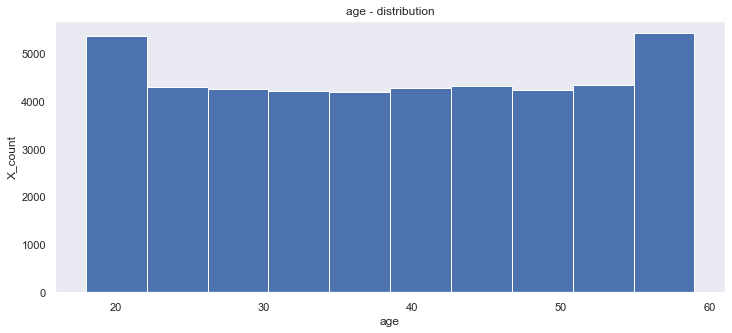

<Figure size 864x360 with 0 Axes>

(array([6.4570e+03, 1.2799e+04, 1.2917e+04, 8.4980e+03, 4.2460e+03,
        1.7340e+03, 5.3000e+02, 1.9300e+02, 5.1000e+01, 1.2000e+01]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <a list of 10 Patch objects>)

Text(0.5, 0, 'num_family')

Text(0, 0.5, 'X_count')

Text(0.5, 1.0, 'num_family - distribution')

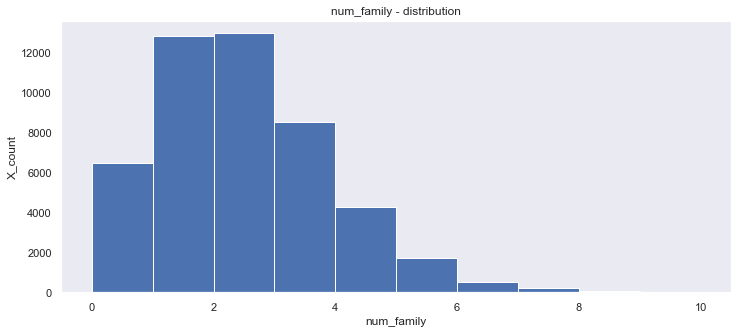

<Figure size 864x360 with 0 Axes>

(array([1.4005e+04, 2.2377e+04, 7.9510e+03, 2.1810e+03, 6.3600e+02,
        2.1700e+02, 7.2000e+01, 2.6000e+01, 1.1000e+01, 5.0000e+00]),
 array([  41. ,  327.8,  614.6,  901.4, 1188.2, 1475. , 1761.8, 2048.6,
        2335.4, 2622.2, 2909. ]),
 <a list of 10 Patch objects>)

Text(0.5, 0, 'income')

Text(0, 0.5, 'X_count')

Text(0.5, 1.0, 'income - distribution')

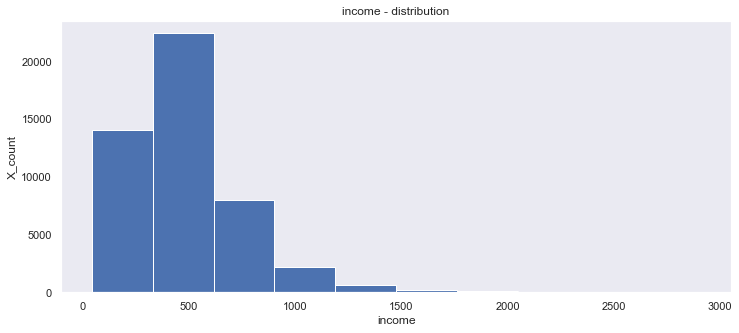

In [11]:

missing_num_columns = [
    'age',
    'num_family',
    'income',
]

for col in missing_num_columns:
    plt.figure(figsize=(12,5))
    plt.hist(users[col])
    plt.xlabel(f'{col}')
    plt.ylabel('X_count')
    plt.title(f'{col} - distribution')
    plt.show()

#### distribution of 'married' and 'country'

<Figure size 864x360 with 0 Axes>

Text(0.5, 1.0, 'married - distribution')

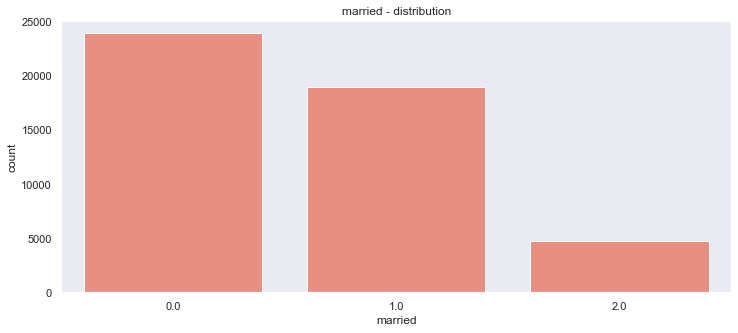

<Figure size 864x360 with 0 Axes>

Text(0.5, 1.0, 'country - distribution')

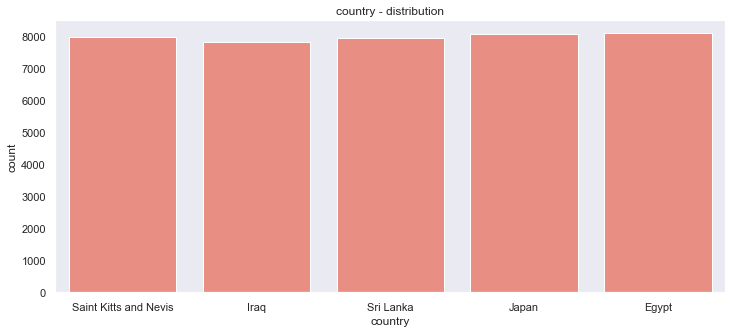

In [12]:
missing_cat_col = [
    'married',
    'country'
]

for col in missing_cat_col:
    plt.figure(figsize=(12,5))
    sns.countplot(x=col, data=users, color='salmon')
    plt.title(f'{col} - distribution')
    plt.show()

### How we complement the missing values
**Mean Value:** 'age', 'num_family', 'income'<br>
**Mode:** 'married', 'country


In [13]:
for col in missing_num_columns:
    column_mean = users_item_num[col].mean()
    users_item_num[col].fillna(column_mean, inplace=True)

In [14]:
for col in missing_cat_col:
    column_mode = users_item_num[col].mode()[0] # there are multiple choices in mode, so just get the first one
    users_item_num[col].fillna(column_mode, inplace=True)

***

# 2. Create Feature Values

## Note: 
<li>incomeの平均値が５００の国と１００の国とではincomeの値が持つ意味合いが異なる
    
**仮説：**　incomeの平均が高い国のユーザー（A）は、incomeの平均が低い国のユーザー（B)と比較して生活に必要な収入も高いため、AとBの収入が同じならば可処分所得は相対的に低くなる　（Aの方が自由に使えるお金は少ない）


<li>'country', 'job' ごとの　'income','age' に関する基本的な統計量を特徴として加える

<Figure size 1080x504 with 0 Axes>

Text(0.5, 1.0, 'Distributions of Income(job)')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 30 Text xticklabel objects>)

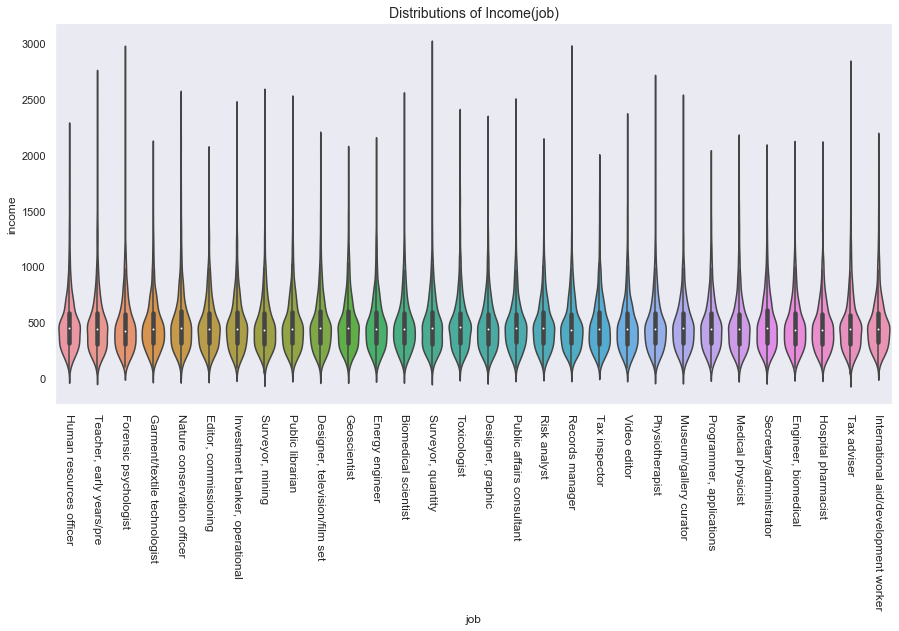

In [15]:
plt.figure(figsize=(15,7))
sns.violinplot(x = 'job', y = 'income', data=users_item_num, split=True)

plt.title('Distributions of Income(job)', fontsize = 14)
plt.xticks(rotation=-90, fontsize=12)

jobごとのincomeの分布をusers_item_numに特徴量として追加する

In [16]:
value_agg = {
    'age':['max','min','mean','std'],
    'income':['max','min','mean','std'],
}

for key in ['country', 'job']:
    feature_df = grouping(users_item_num, key, value_agg, prefix=key + '_')
    users_item_num = pd.merge(users_item_num, feature_df, how='left', on=key)

<li> userのincome、ageが、各グループの平均income、ageからどれくらい乖離しているか
<li> userの家族一人あたりの収入：income/num_family
<li> 各グループのincome, ageの分布の幅（最大値と最小値の差）

In [17]:
for col in ['country','job']:
    for value in ['age','income']:
        users_item_num[f'{value}_diff_mean_{col}'] = users_item_num[col+'_'+value+'_mean'] - users_item_num[value]
        users_item_num[f'{value}_diff_max_min_{col}'] = users_item_num[col+'_'+value+'_max'] - users_item_num[col+'_'+value+'_min']
        
users_item_num['income_per_num_family'] = users_item_num['income'] / (users_item_num['num_family']+1)

In [18]:
users_item_num.head()

,user_id,name,nickname,age,country,num_family,married,job,income,profile,...,job_income_std,age_diff_mean_country,age_diff_max_min_country,income_diff_mean_country,income_diff_max_min_country,age_diff_mean_job,age_diff_max_min_job,income_diff_mean_job,income_diff_max_min_job,income_per_num_family
0,14742,Richard Chen,kathryn77,20.000000,Egypt,1.000000,0.0,Human resources officer,394.0,Last sit star physical accept. Actually relate...,...,253.751663,18.488919,41.0,87.814959,2597.0,18.871353,41.0,90.455412,2100.0,197.000000
1,21530,Kayla Garcia,brandtalexander,59.000000,Saint Kitts and Nevis,4.000000,0.0,"Teacher, early years/pre",370.0,Door entire as. Whose suddenly mission hold.\n...,...,270.619618,-20.395692,41.0,111.484634,2396.0,-20.111083,41.0,117.119827,2569.0,74.000000
2,34985,Troy Blackwell,richardfarmer,44.000000,Iraq,3.000000,2.0,Forensic psychologist,326.0,Writer drug a tax. Team standard both write pr...,...,242.034700,-5.583670,41.0,156.984206,2796.0,-5.811597,41.0,142.473441,2769.0,81.500000
3,31854,Suzanne Ray,nicole40,52.000000,Sri Lanka,1.999072,0.0,Garment/textile technologist,673.0,Evidence try next degree man local. Movie sea ...,...,241.025513,-13.204261,41.0,-187.787870,2837.0,-13.745407,41.0,-189.994102,1945.0,224.402715
4,46689,Susan Horn,heather38,38.544257,Japan,1.000000,0.0,Nature conservation officer,306.0,Voice after assume hard tonight. Recent try ma...,...,261.818781,-0.057622,41.0,183.089053,2334.0,-0.213972,41.0,188.977408,2375.0,153.000000


## 学習に使用する特徴量

学習に使用するカラム
<li> feature_num_columns - 特徴量として使用する数値カラム
<li> cat_columns - 特徴量として使用する　categorical variables カラム
<li> target_column - 目的変数である　X $\in$ {0,1}　が入っているカラム

In [19]:
# train に使用する　columnsを選択する
def choose_feature_column(df, feature_cat_columns): # df内のcategoricalカラムを除いたカラム
    feature_num_columns = [col for col in df.columns
                          if col not in ['user_id', 'X']
                          and df[col].dtype != 'O'
                          and col not in feature_cat_columns]
   
    return feature_num_columns

feature_cat_columns = ['country','job','married']
feature_num_columns = choose_feature_column(users_item_num, feature_cat_columns)
target_column = 'X'

In [20]:
feature_num_columns

['age',
 'num_family',
 'income',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'country_age_max',
 'country_age_min',
 'country_age_mean',
 'country_age_std',
 'country_income_max',
 'country_income_min',
 'country_income_mean',
 'country_income_std',
 'job_age_max',
 'job_age_min',
 'job_age_mean',
 'job_age_std',
 'job_income_max',
 'job_income_min',
 'job_income_mean',
 'job_income_std',
 'age_diff_mean_country',
 'age_diff_max_min_country',
 'income_diff_mean_country',
 'income_diff_max_min_country',
 'age_diff_mean_job',
 'age_diff_max_min_job',
 'income_diff_mean_job',
 'income_diff_max_min_job',
 'income_per_num_family']

In [21]:
users_item_num.drop(['user_id','name', 'nickname', 'profile'], axis=1, inplace=True)
feature_cat_columns = ['country','job','married']
target_column = 'X'

***

# 3. モデルの評価方法を決める

## Split the data to train & test

In [22]:
X = users_item_num[feature_num_columns] # Feature
y = users_item_num[target_column] # Target

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

## Create a validation data

## <li> KFold Cross Validation

In [24]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

## <li>Stratified K-Fold Cross Validation
    各Foldのtarget：X の割合をほぼ等しくする

In [25]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for iteration, (train_index, val_index) in enumerate(skf.split(X_train, y_train)): # 検証データをずらして５回繰り返す
    
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    y_train_positive_ratio = y_train_fold.mean()
    y_val_positive_ratio = y_val_fold.mean()
    
    print(f'Iteration {iteration}: train {y_train_positive_ratio:.1%} val {y_val_positive_ratio:.1%}')

Iteration 0: train 10.4% val 10.4%
Iteration 1: train 10.4% val 10.4%
Iteration 2: train 10.4% val 10.4%
Iteration 3: train 10.4% val 10.4%
Iteration 4: train 10.4% val 10.4%


***

# 4. Modeling
## <li> Logistic Regression
    - Need to create dummies and standardize
## <li>  Random Forest
    - Only need to create dummies

In [26]:
from sklearn.model_selection import KFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier

In [27]:
X = users_item_num[feature_num_columns + feature_cat_columns]
y = users_item_num[target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

In [28]:

from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder # To create dummies

# Logistic Regression
lr_model = make_pipeline(
    OneHotEncoder(cols=feature_cat_columns, use_cat_names=True),
    StandardScaler(),
    LogisticRegression(),
)


# Random Forest
rf_model = make_pipeline(
    OneHotEncoder(cols=feature_cat_columns, use_cat_names=True),
    RandomForestClassifier(),
)

### Evaluate

In [29]:
lr_scores = cross_validate(lr_model, X_train, y_train, cv=kf, scoring='roc_auc', return_estimator=True)
print('LR', lr_scores['test_score'].mean())

rf_scores = cross_validate(rf_model, X_train, y_train, cv=kf, scoring='roc_auc', return_estimator=True)
print('RF', rf_scores['test_score'].mean())

/Users/ayumi.matsuoka/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ayumi.matsuoka/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ayumi.matsuoka/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ayumi.matsuoka/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ayumi.matsuoka/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarn

LR 0.653455962519973


/Users/ayumi.matsuoka/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/ayumi.matsuoka/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/ayumi.matsuoka/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/ayumi.matsuoka/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/a

RF 0.6210111515830128


***

# 5. Adjusting Hyper Parameters

**Logistic Regression:** penalty (elasticnet), l1_ratio (0~1), C(small value = Big penalty)<br>
**Random Forest:** n_estimators(number of decision trees)<br>

大きい値を設定した方が精度は上がるが、計算時間がかかるため、何種類か試して十分な精度を手に入れればok

### Hyper Parameter  の調整方法
良し悪しを評価するのはバリデーションにおける精度。試すハイパーパラメータを決めて、バリデーションで精度を確認、の作業を何度も繰り返す

In [31]:
from sklearn.model_selection import GridSearchCV

# make_pipelineを使った場合、クラス名とパラメータ名をアンダーバー２つでつなぐ
lr_params = {
    'logisticregression__penalty': ['elasticnet'], # penaltyは　elasticnetのみ
    'logisticregression__solver': ['saga'], #elasticnetを使う時は saga を指定する
    'logisticregression__l1_ratio': [i*0.2 for i in range(6)], # 0から1の範囲で0.1刻み
    'logisticregression__C': [10**i for i in range(-3,4)] # 10^(-3)から2^3の範囲で
}

rf_params = {
    'randomforestclassifier__n_estimators': [100*i for i in range(1, 6)] # 100から500まで100刻み
}

# scoring と cv の指定をする
lr_gscv = GridSearchCV(lr_model, lr_params, scoring='roc_auc', cv=kf)
rf_gscv = GridSearchCV(rf_model, rf_params, scoring='roc_auc', cv=kf)

# グリッドサーチを実行
lr_gscv.fit(X_train, y_train)

print('Logistic Regression')
print(f'best_score: {lr_gscv.best_score_}')
print(f'best_params: {lr_gscv.best_params_}')

rf_gscv.fit(X_train, y_train)

print('RandomForest')
print(f'best_score: {rf_gscv.best_score_}')
print(f'best_params: {rf_gscv.best_params_}')



/Users/ayumi.matsuoka/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/ayumi.matsuoka/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/ayumi.matsuoka/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/ayumi.matsuoka/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/ayumi.matsuoka/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('onehotencoder',
                                        OneHotEncoder(cols=['country', 'job',
                                                            'married'],
                                                      drop_invariant=False,
                                                      handle_missing='value',
                                                      handle_unknown='value',
                                                      return_df=True,
                                                      use_cat_names=True,
                                                      verbose=0)),
                                       ('standardscaler',
                                        StandardScaler(copy=Tr...
                                                           warm_start

Logistic Regression
best_score: 0.6567897921293254
best_params: {'logisticregression__C': 0.01, 'logisticregression__l1_ratio': 0.8, 'logisticregression__penalty': 'elasticnet', 'logisticregression__solver': 'saga'}


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('onehotencoder',
                                        OneHotEncoder(cols=['country', 'job',
                                                            'married'],
                                                      drop_invariant=False,
                                                      handle_missing='value',
                                                      handle_unknown='value',
                                                      return_df=True,
                                                      use_cat_names=True,
                                                      verbose=0)),
                                       ('randomforestclassifier',
                                        RandomForestCl...
                                                               min_sa

RandomForest
best_score: 0.7013213897680775
best_params: {'randomforestclassifier__n_estimators': 500}


***

# 6. Checking with Test Data

In [34]:
from sklearn.metrics import roc_auc_score

# target = 1 の確率を得るには、[:, 1]でアクセスすれば良い 
lr_pred = lr_gscv.predict_proba(X_test)[:, 1]
rf_pred = rf_gscv.predict_proba(X_test)[:, 1]

print('LR', roc_auc_score(y_test, lr_pred))
print('RF', roc_auc_score(y_test, rf_pred))

LR 0.6448146686923748
RF 0.6944865894904818
